In [1]:
from skimage import transform as tranf
import tensorflow as tf

In [2]:
# Importando dataset
!wget -nc https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O /content/cats_and_dogs_filtered.zip

import os, cv2, numpy as np
import zipfile
from matplotlib import pyplot as plt #importa bilbioteca para criação de gráficos
from sklearn.model_selection import train_test_split 

local_zip = '/content/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()
base_dir = '/content/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats') # Diretório com imagens de treinamentos de gatos
train_dogs_dir = os.path.join(train_dir, 'dogs') # Diretório com imagens de treinamentos de cachorros
validation_cats_dir = os.path.join(validation_dir, 'cats') # Diretório com i magens de teste de gatos
validation_dogs_dir = os.path.join(validation_dir, 'dogs') # Diretório com i magens de teste de cachorros

File ‘/content/cats_and_dogs_filtered.zip’ already there; not retrieving.


1) Importar as imagens nos 4 diretórios acima e juntá-los em dois grupos, X e Y. Ou
seja, junte os dados de treinamento e validação em um único array. Para realizar a
leitura, você pode utilizar a função cv2.imread do pacote cv2.

In [3]:
X = []
Y = []

folder='/content/cats_and_dogs_filtered'
for subdir, dirs, files in os.walk(folder):
    for file in files:
        if file.endswith('.jpg'):
          X.append(cv2.imread(os.path.join(subdir, file)))
          if file[:3] == 'cat':
            Y.append(0)
          elif file[:3] == 'dog':
            Y.append(1)
          else:
            print('Algo de errado não está certo')

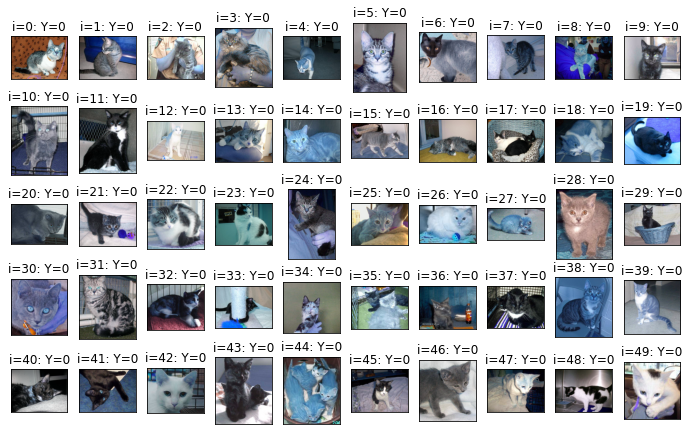

In [4]:
# Amostra das imagens
plt.figure(figsize=(12,12))
for i in range(50):
    plt.subplot(8,10,i+1)
    plt.imshow(X[i], cmap=plt.cm.gray_r);
    plt.title('i='+str(i)+': Y='+ str(Y[i]));
    plt.xticks([]);
    plt.yticks([]);

2) Você deve redimensionar as imagens para (220,128), através da função
cv2.resize(image, (220, 128)).


In [5]:
X_rsz = []
for img in (X):
  X_rsz.append(cv2.resize(img, (220, 128)))

In [6]:
np.shape(X_rsz)

(3000, 128, 220, 3)

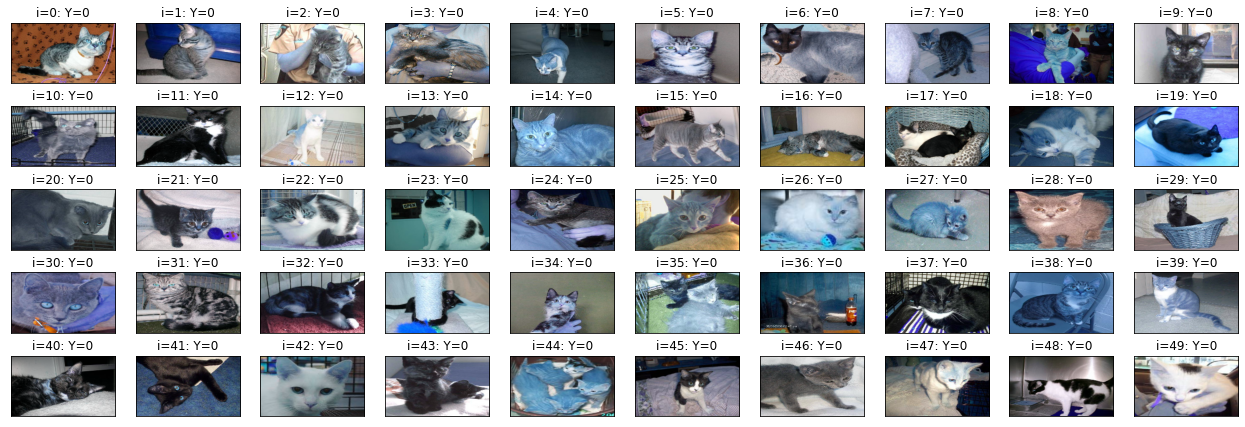

In [7]:
# Amostra das imagens
plt.figure(figsize=(22,12))
for i in range(50):
    plt.subplot(8,10,i+1)
    plt.imshow(X_rsz[i], cmap=plt.cm.gray_r);
    plt.title('i='+str(i)+': Y='+ str(Y[i]));
    plt.xticks([]);
    plt.yticks([]);

3) Gerar imagens através de data augmentation, variando a largura e a altura em 20%,
e rotacionando a imagem em ângulos de 45%.

In [8]:
def data_aug(X_rsz, Y_rsz, num_imgs):
  X_modified = np.zeros((2*len(X_rsz), 128, 220, 3))
  Y_modified = []
  result_X = np.zeros((num_imgs, 128, 220, 3))
  result_Y = []
  X_aux = []

  # Distorce altura e/ou largura em 20%
  for i, img in enumerate(X_rsz):
    rdn1 = np.random.choice([0.8, 1])
    rdn2 = np.random.choice([0.8, 1])

    X_aux = tranf.resize(X_rsz[i], (np.int(rdn2*128), np.int(rdn1*220)))
    if rdn1 == 0.8:
      X_aux = np.concatenate((X_aux, np.zeros((np.shape(X_aux)[0],44,3))), axis=1)
    if rdn2 == 0.8:
      X_aux = np.concatenate((X_aux, np.zeros((26,220,3))), axis=0)

    X_modified[i,:,:,:] = X_aux
    Y_modified.append(Y_rsz[i])

  # Rotaciona as imagens em variações de 45  graus
  for i, img in enumerate(X_rsz):
    rdn = np.random.randint(1,4)
    X_aux = tranf.rotate(X_rsz[i], angle=rdn*45)
    X_modified[i+len(X_rsz),:,:,:] = X_aux
    Y_modified.append(Y_rsz[i])

  sorteados = np.random.randint(0,len(X_modified),num_imgs)

  for k, isort in enumerate(sorteados):
    result_X[k,:,:,:] = X_modified[isort]
    result_Y.append(Y_modified[isort])

  return result_X, result_Y

In [9]:
np.int(220*0.8)

176

In [10]:
128-np.int(128*0.8)

26

4) Criar 1000 imagens através do data augmentation e adicioná-las às imagens já
existentes.


In [11]:
X_aug, Y_aug = data_aug(X_rsz, Y, 1000)
print(np.shape(X_aug))
print(np.shape(Y_aug))

(1000, 128, 220, 3)
(1000,)


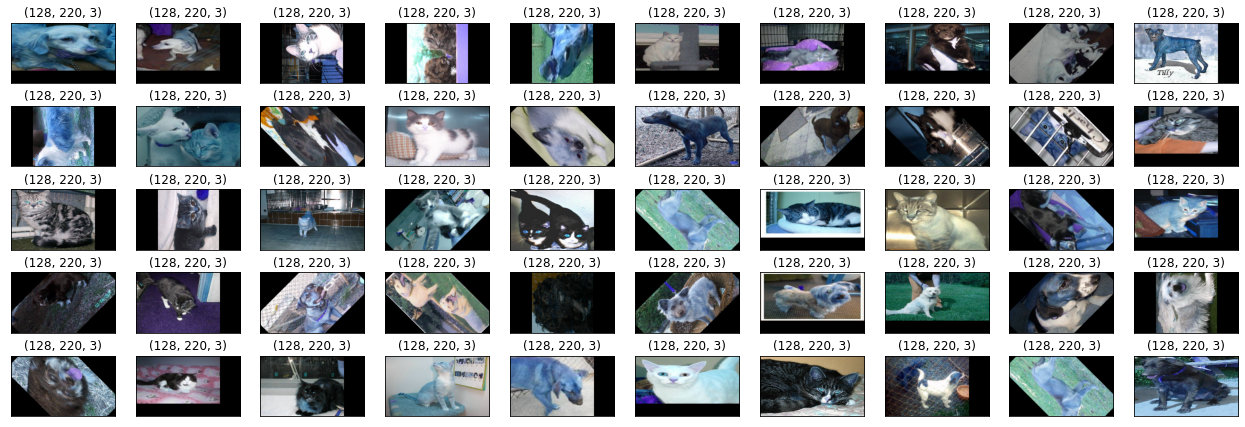

In [12]:
# Amostra das imagens
plt.figure(figsize=(22,12))
for i in range(50):
    plt.subplot(8,10,i+1)
    plt.imshow(X_aug[i], cmap=plt.cm.gray_r);
    plt.title(np.shape(X_aug[i]));
    plt.xticks([]);
    plt.yticks([]);

In [13]:
print(np.shape(X_rsz))
X_f = np.concatenate((X_rsz, X_aug), axis=0)/255
print(np.shape(X_f))

(3000, 128, 220, 3)
(4000, 128, 220, 3)


In [14]:
Y_f = Y
print(np.shape(Y_f))
Y_f.extend(Y_aug)
print(np.shape(Y_f))

(3000,)
(4000,)


5) Utilizar o método train_test_split do pacote sklearn.model_selection para separar os
dados entre conjuntos de treino e teste. Utilize 30% dos dados para teste (parâmetro
test_size).

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_f, np.asarray(Y_f, dtype=np.int), test_size=0.3, random_state=42)

In [16]:
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(2800, 128, 220, 3)
(2800,)
(1200, 128, 220, 3)
(1200,)


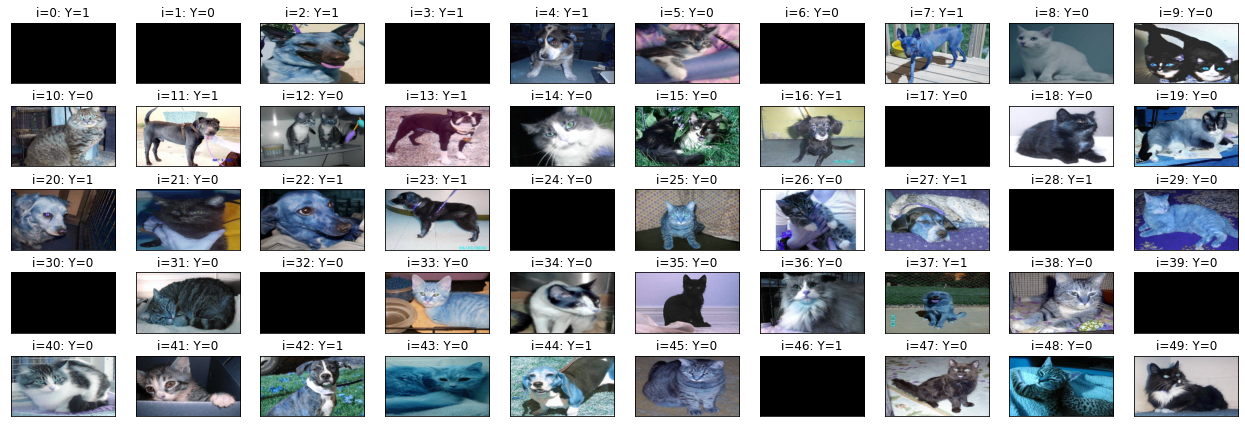

In [17]:
# Amostra das imagens de treinamento
plt.figure(figsize=(22,12))
for i in range(50):
    plt.subplot(8,10,i+1)
    plt.imshow(X_train[i], cmap=plt.cm.gray_r);
    plt.title('i='+str(i)+': Y='+ str(y_train[i]));
    plt.xticks([]);
    plt.yticks([]);

6) Instancie as três redes acima com os dados de treino teste.

In [18]:
#VGG16
model1 = tf.keras.applications.VGG16(classes=2, classifier_activation='Softmax', include_top = True, weights = None, input_shape = (128,220,3))
print(model1.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 220, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 220, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 220, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 110, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 110, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 110, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 55, 128)       0     

In [19]:
model1.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
np.array.

In [20]:
history = model1.fit(X_train, y_train, batch_size=56, epochs=1, validation_data=(X_test, y_test))

KeyboardInterrupt: ignored

In [24]:
#VGG19
model2 = tf.keras.applications.VGG19(classes=2, classifier_activation='Softmax', include_top = True, weights = None, input_shape = (128,220,3))
print(model2.summary())

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 220, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 220, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 220, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 110, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 110, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 110, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 55, 128)       0     

In [22]:
model2.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
history = model2.fit(X_train, y_train, batch_size=56, epochs=1, validation_data=(X_test, y_test))

In [25]:
#VGG16
model3 = tf.keras.applications.resnet.ResNet152(classes=2, classifier_activation='Softmax', include_top = True, weights = None, input_shape = (128,220,3))
print(model3.summary())

Model: "resnet152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 220, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 226, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 110, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 110, 64)  256         conv1_conv[0][0]                 
__________________________________________________________________________________________